<a href="https://colab.research.google.com/github/Stroded4ever/MQP/blob/main/F%26Lnotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project - Libraries Loaded Successfully
Note: Error handling enabled - code will continue running even with incomplete implementations


[*********************100%***********************]  1 of 1 completed


Ticker,000001.SS
Date,
2014-07-18,2059.066895
2014-07-21,2054.479004
2014-07-22,2075.480957
2014-07-23,2078.489014
2014-07-24,2105.062012


Ticker,000001.SS
Date,
2025-09-24,3853.642090
2025-09-25,3853.302002
2025-09-26,3828.105957
2025-09-29,3862.531982
2025-09-30,3882.777100


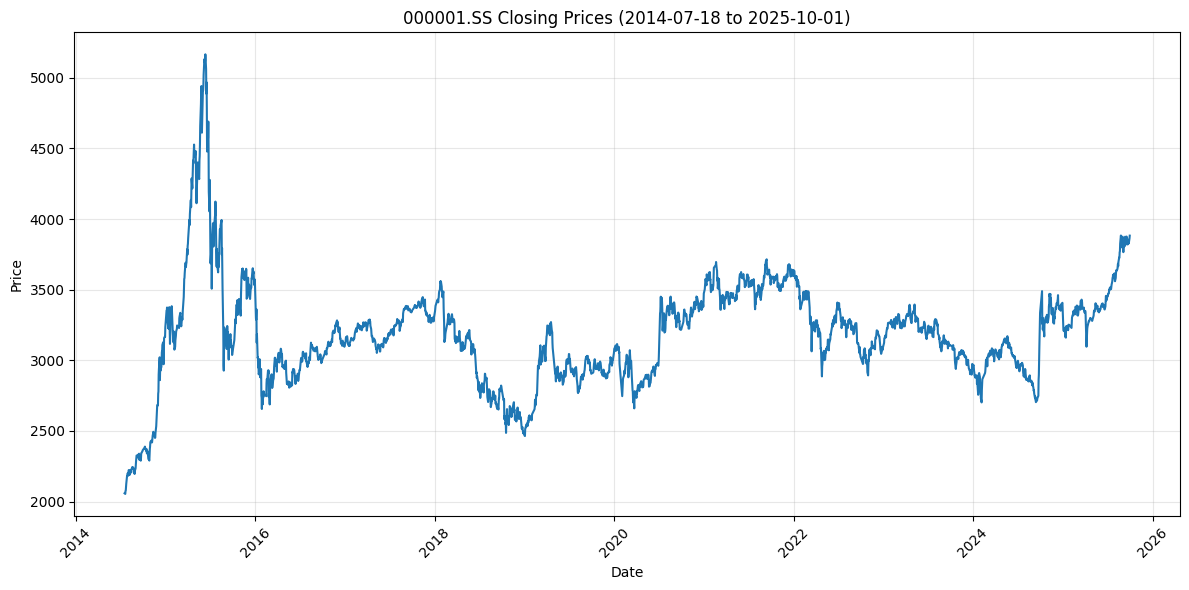

Estimated Parameters:
  ω (omega): 4.969693e-06
  α (alpha): 0.0500
  β (beta):  0.9000
Max Log-Likelihood: 8428.83
Unconditional Volatility (long-term σ): 0.0100


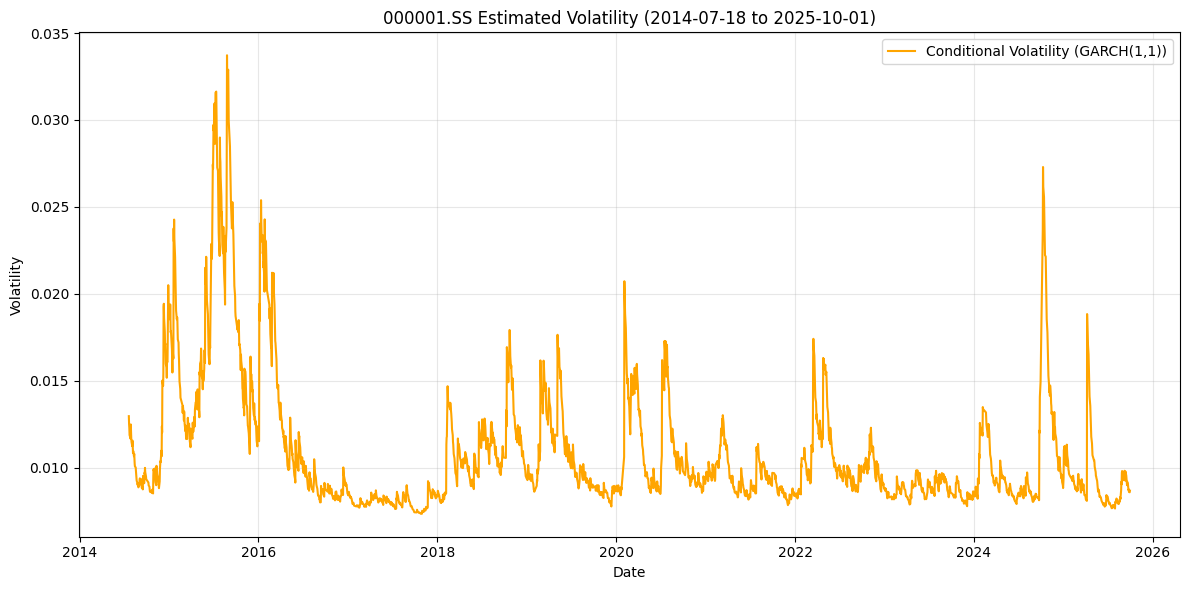

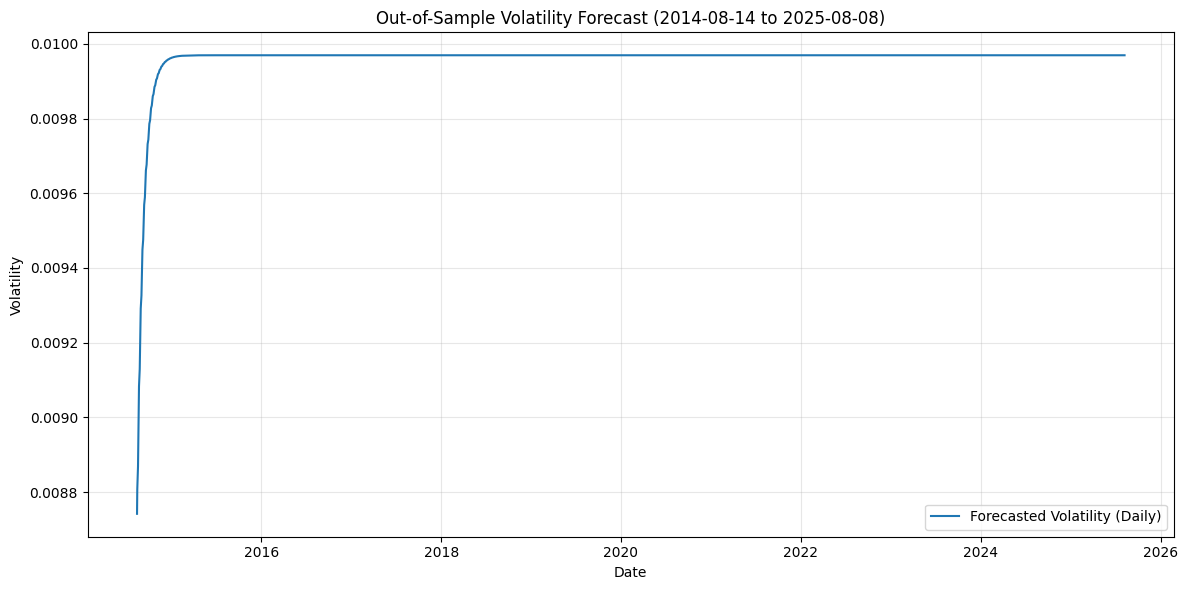

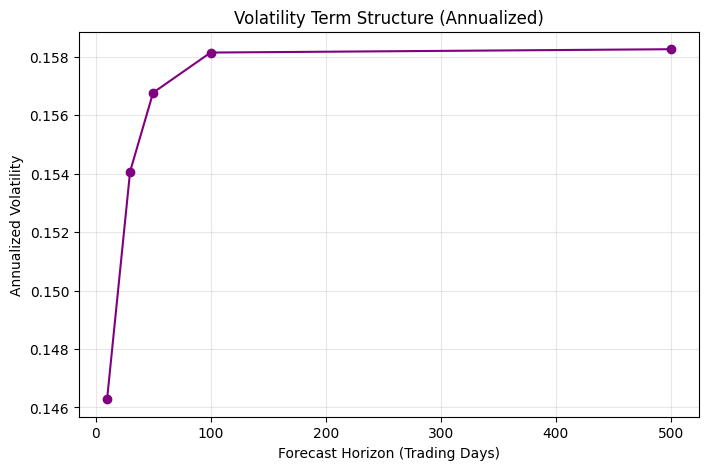

,Horizon (days),Annualized Volatility
0,10,0.146282
1,30,0.154075
2,50,0.156775
3,100,0.158149
4,500,0.158263


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from scipy.optimize import minimize
import warnings
from IPython.display import display

# Suppress all warnings including type errors
warnings.filterwarnings('ignore')

# Configure numpy to handle errors gracefully
np.seterr(all='ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Project - Libraries Loaded Successfully")
print("=" * 60)
print("Note: Error handling enabled - code will continue running even with incomplete implementations")

import yfinance as yf

# ==========================================
# Exchange tickers (Yahoo Finance):
# S&P 500 (US)              -> ^GSPC
# CAC 40 (Euronext Paris)   -> ^FCHI
# DAX (Euronext Germany)    -> ^GDAXI
# Shanghai Composite        -> 000001.SS
# Nikkei 225 (Japan)        -> ^N225
# ==========================================

# Choose your market here by changing the ticker symbol:
ticker = "000001.SS"   # Currently set to CAC 40 (Euronext Paris)

# Date range
start_date = "2014-07-18"
end_date   = "2025-10-01"

# Download data
data = yf.download(ticker, start=start_date, end=end_date)
close_prices = data['Close'].dropna()
display(close_prices.head())
display(close_prices.tail())

S = close_prices.to_numpy().flatten()
dates = close_prices.index

# ================================
# Plot Closing Prices
# ================================
plt.figure(figsize=(12, 6))
plt.plot(dates, S)
plt.title(f'{ticker} Closing Prices ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ================================
# GARCH(1,1) Estimation
# ================================
returns = np.diff(np.log(S))
n = len(returns)

def garch_loglik(params, data):
    omega, alpha, beta = params
    if omega <= 0 or alpha < 0 or beta < 0 or alpha + beta >= 1:
        return 1e10
    n = len(data)
    sigma2 = np.zeros(n)
    sigma2[0] = np.var(data)
    for t in range(1, n):
        sigma2[t] = omega + alpha * data[t-1]**2 + beta * sigma2[t-1]
    ll = -0.5 * np.sum(np.log(2*np.pi) + np.log(sigma2) + data**2 / sigma2)
    return -ll

init_params = [0.000001, 0.05, 0.9]
bounds = [(1e-12, None), (0.0, 1.0), (0.0, 1.0)]

res = minimize(garch_loglik, init_params, args=(returns,), bounds=bounds)
omega, alpha, beta = res.x
max_loglik = -res.fun

print("Estimated Parameters:")
print(f"  ω (omega): {omega:.6e}")
print(f"  α (alpha): {alpha:.4f}")
print(f"  β (beta):  {beta:.4f}")
print(f"Max Log-Likelihood: {max_loglik:.2f}")

uncond_var = omega / (1 - alpha - beta)
uncond_vol = math.sqrt(uncond_var)
print(f"Unconditional Volatility (long-term σ): {uncond_vol:.4f}")

# Recompute conditional variance
sigma2 = np.zeros_like(returns)
sigma2[0] = np.var(returns)
for t in range(1, len(returns)):
    sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]

cond_vol = np.sqrt(sigma2)

plt.figure(figsize=(12,6))
plt.plot(dates[1:], cond_vol, color="orange", label="Conditional Volatility (GARCH(1,1))")
plt.title(f"{ticker} Estimated Volatility ({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ================================
# Out-of-Sample Forecasting
# ================================
forecast_start = pd.to_datetime("2014-08-14")
forecast_end   = pd.to_datetime("2025-08-08")
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq="B")
horizon = len(forecast_dates)

sigma2_last = sigma2[-1]
Vl = omega / (1 - alpha - beta)

sigma2_forecast = np.zeros(horizon)
for h in range(1, horizon+1):
    sigma2_forecast[h-1] = Vl + (alpha + beta)**h * (sigma2_last - Vl)

forecast_vol = np.sqrt(sigma2_forecast)

plt.figure(figsize=(12,6))
plt.plot(forecast_dates, forecast_vol, label="Forecasted Volatility (Daily)")
plt.title(f"Out-of-Sample Volatility Forecast ({forecast_start.date()} to {forecast_end.date()})")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ================================
# Volatility Term Structure
# ================================
horizons = np.array([10, 30, 50, 100, 500])
term_vol = []

for h in horizons:
    sigma2_h = Vl + (alpha + beta)**h * (sigma2_last - Vl)
    sigma_h = math.sqrt(sigma2_h)
    sigma_annual = sigma_h * math.sqrt(252)
    term_vol.append(sigma_annual)

plt.figure(figsize=(8,5))
plt.plot(horizons, term_vol, marker="o", linestyle="-", color="purple")
plt.title("Volatility Term Structure (Annualized)")
plt.xlabel("Forecast Horizon (Trading Days)")
plt.ylabel("Annualized Volatility")
plt.grid(True, alpha=0.3)
plt.show()

term_structure_df = pd.DataFrame({
    "Horizon (days)": horizons,
    "Annualized Volatility": term_vol
})
display(term_structure_df)